## импорт библиотек

In [13]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

## некоторые настройки

In [14]:
# кол-во символов для показа
pd.options.display.max_colwidth = 74
# выводить все столбцы
pd.set_option('display.max_columns', None)
# размер плота
plt.rcParams['figure.figsize'] = (13,5)

## Функции

In [15]:
# ф-я принимает серию возвращает кортеж :
# [0]-25% перцентиль серии
# [1]-75% перцентиль серии
# [2]-IQR
# [3]-нижняя граница выбросов
# [4]-верхняя граница выбросов
def get_bounds(ser):
    perc25 = ser.quantile(0.25)
    perc75 = ser.quantile(0.75)
    IQR = perc75-perc25

    return (perc25, perc75, IQR, perc25-1.5*IQR, perc75+1.5*IQR)

# ф-я выводит 25% и 75% перцентили серии, IQR, границы выбросов, рисует гистограмму по серии, исключая выбросы
def print_hist(ser):
    bounds = get_bounds(ser)

    print(
        '25-й перцентиль: {},'.format(bounds[0]),
        '75-й перцентиль: {},'.format(bounds[1]),
        "IQR: {},".format(bounds[2]),
        "Границы выбросов: [{L},{H}].".format(L=bounds[3], H=bounds[4])
    )

    ser.loc[ser.between(bounds[3], bounds[4])].hist(
        bins=16, range=(ser.min(), ser.max()), label='IQR')

    plt.legend()

# ф-я округляет полученное предсказание рэйтинга до ближайшего шага
def round_rating_pred(rating_pred):
    if rating_pred <= 0.5:
        return 0.0
    if rating_pred <= 1.5:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0

## загрузка данных

In [16]:
DATA_DIR = 'data'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_control = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

###### Для корректной обработки данных (чтобы и тренировочный и контрольный датасет имели идентичный набор столбцов) объединим датасеты в один с созданием признака, определяющего принадлежность данных к тесту или контролю

In [17]:
df_train['Markup'] = 1 # это тренировочные данные
df_control['Markup'] = 0  # это контрольные данные

df_control['Rating'] = 0 # контрольный набор данных не содержит поля Rating, поэтому создатим и предзаполним нулями

df = pd.DataFrame() # будем использовать для предварительного заполнения признаками
df_dr = df_control.append(df_train, sort=False).reset_index(drop=True) # объединяем в черновике df_dr ~ DataFrame Dirt
df_cl = pd.DataFrame() # чистовик, пока пустой df_cl ~ DataFrame Clean


In [18]:
df_dr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   Markup             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [19]:
df_dr.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Markup,Rating
21467,id_2259,Munich,"['Steakhouse', 'Barbecue', 'European']",2275.0,$$ - $$$,187.0,"[['Asado Steak missing authentic feel and sou...', 'Meat did not meet ...",/Restaurant_Review-g187309-d1011902-Reviews-Asado_Steak-Munich_Upper_B...,d1011902,1,3.0
27414,id_10045,London,"['Mediterranean', 'Turkish', 'Middle Eastern', 'Halal']",10054.0,NaN,18.0,"[['Excellent Turkish food near the Holloway R...', 'never fails with t...",/Restaurant_Review-g186338-d4176719-Reviews-Noa_Noa-London_England.html,d4176719,1,4.5
46219,id_1308,Amsterdam,"['Dutch', 'Bar', 'Cafe', 'European', 'Pub']",1311.0,$,45.0,"[['Unique building', 'A great lunch in a unique building.'], ['04/27/2...",/Restaurant_Review-g188590-d6627515-Reviews-V_O_C_Cafe-Amsterdam_North...,d6627515,1,4.0
37050,id_2364,Budapest,NaN,2365.0,NaN,6.0,"[['Little friendly place for locals', 'Gastronomical Passport'], ['04/...",/Restaurant_Review-g274887-d7712878-Reviews-Passport_Etterem_ES_Kaveha...,d7712878,1,2.5
35814,id_1047,Zurich,NaN,1051.0,NaN,14.0,"[['Nice', 'Best pizza'], ['10/19/2016', '05/26/2015']]",/Restaurant_Review-g188113-d4150234-Reviews-Romerblick-Zurich.html,d4150234,1,4.0


###### заполним чистовик данными, которые пока не подлежат обработке : Markup, Ranking, Rating, Price_Range (преобразуем), 

In [20]:
df_cl['Markup'] = df_dr['Markup']
df_cl['Ranking'] = df_dr['Ranking']
df_cl['Rating'] = df_dr['Rating']
# А диапазон цен сразу преобразуем в числовой формат  
df_cl['Price_Range_num'] = df_dr['Price Range'].replace(to_replace={'$':1, '$$ - $$$':2, '$$$$':3})

# Медианное значение диапазона цен 
Price_Range_median = df_cl['Price_Range_num'].median()

# Пустоты диапазона просто заполним медианой (это 2 ($$-$$$))
df_cl['Price_Range_num'] = df_cl['Price_Range_num'].fillna(Price_Range_median)

# Медианное значение кол-ва ревью 
Number_reviews_median = df_dr['Number of Reviews'].median()

# ВВедем признак пустоты кол-ва ревью:
df_cl['Number_of_Reviews_isNAN'] = pd.isna(df_dr['Number of Reviews']).astype('uint8')

# Пустоты по кол-ву ревью заполним медианой
df_cl['Number of Reviews'] = df_dr['Number of Reviews'].fillna(Number_reviews_median)

# Присоединяем к чистовому датасету dummy переменные - города
df_cl['City'] = df_dr['City']
df_cl = pd.get_dummies(df_cl, columns=['City'], dummy_na=True)

# После проделанных действий не должно быть пропусков, проверяем:
#df_cl.info()
df_cl.isna().sum()

Markup                     0
Ranking                    0
Rating                     0
Price_Range_num            0
Number_of_Reviews_isNAN    0
Number of Reviews          0
City_Amsterdam             0
City_Athens                0
City_Barcelona             0
City_Berlin                0
City_Bratislava            0
City_Brussels              0
City_Budapest              0
City_Copenhagen            0
City_Dublin                0
City_Edinburgh             0
City_Geneva                0
City_Hamburg               0
City_Helsinki              0
City_Krakow                0
City_Lisbon                0
City_Ljubljana             0
City_London                0
City_Luxembourg            0
City_Lyon                  0
City_Madrid                0
City_Milan                 0
City_Munich                0
City_Oporto                0
City_Oslo                  0
City_Paris                 0
City_Prague                0
City_Rome                  0
City_Stockholm             0
City_Vienna   

## Stage 1 (MAE = 0.2162)
###### Как промежуточный итог, фиксируем, что модель, построенная на датафрейме c вышеопределенными признаками, показала MAE = 0.2162. 
###### с помощью feature_importances_ модели выявили, что наибольшую важность имеют признаки  Number of Reviews и Ranking. Именно эти признаки изучим более подробно в sStage 2

## Осмотр данных

<AxesSubplot:>

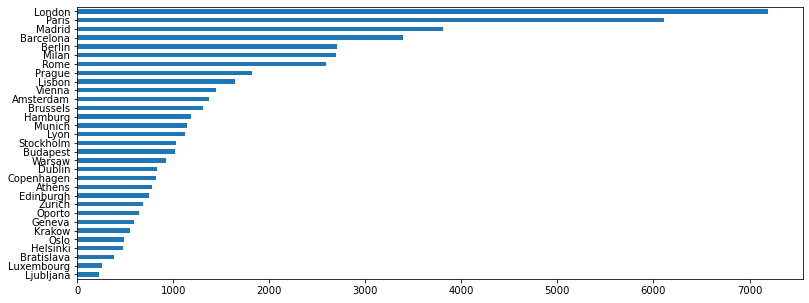

In [21]:
df_dr['City'].value_counts(ascending=True).plot(kind='barh')

###### Более всего ресторанов в Лондоне, а разрыв по количеству громадный - от 7 тыс. до менее 1 тыс. Интересно каков диапазон Ranking в зависимости от города:

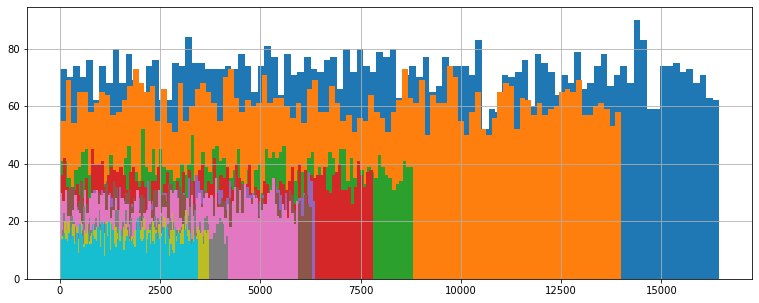

In [22]:
# Цикл по 10 городам, которые встречаются наиболее часто в датасете:
for x in (df_dr['City'].value_counts())[0:10].index:
    df_dr['Ranking'][df_dr['City'] == x].hist(bins =100)
plt.show()

###### Как видим, Ranking очень сильно зависит от кол-ва ресторанов  в городе, необходимо нормализовать Ranking. Это поставит в одинаковые условия рестораны из разных городов.

In [23]:
# для каждой записи, делим ее Ranking на максимальный Ranking из всех записей того же города
df_cl['Ranking_norm'] = df_dr['Ranking'] / df_dr['City'].map(df_dr.groupby(['City'])['Ranking'].max())

# MAE: 0.21440549999999997 witn Ranking and Ranking_norm
# MAE: 0.216946 only with Ranking_norm


###### MAE незначительно уменьшился, но feature importance показал, что введенная переменная вышла на 1-е место по важности с далеким отрывом

###### Попробуем исследовать распределение следующих величин:
- ###### (ЛОгарифм?) Ранг
- ###### (ЛОгарифм?) Ранг/кол-во ресторанов в городе
- ###### (ЛОгарифм?) Нормализованный ранг / кол-во ресторанов в городе

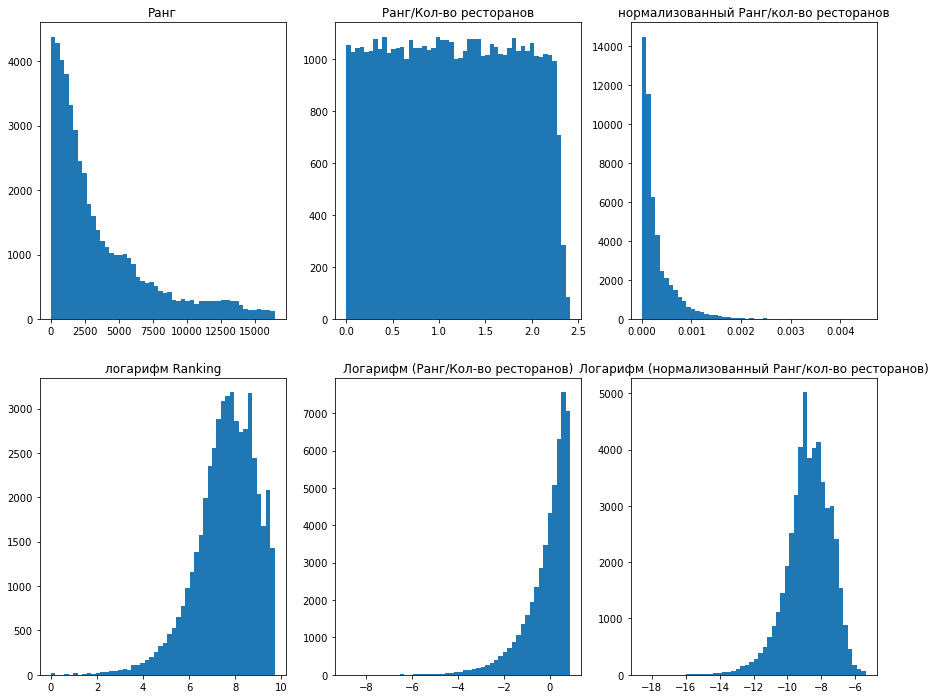

In [24]:
# Сначала найдем кол-во ресторанов в городе для каждой записи
df_dr['rest_in_city'] = df_dr.groupby('City')['Restaurant_id'].transform('count')
df_cl['rest_in_city'] = df_dr['rest_in_city']


fig, axes = plt.subplots(2,3, figsize=(15,12))

axes[0][0].hist(df_cl['Ranking'], bins=50)
axes[0][0].set_title('Ранг')

axes[0][1].hist(df_dr['Ranking']/df_dr['rest_in_city'], bins=50)
axes[0][1].set_title('Ранг/Кол-во ресторанов')

axes[0][2].hist(df_cl['Ranking_norm']/df_cl['rest_in_city'], bins=50)
axes[0][2].set_title('нормализованный Ранг/кол-во ресторанов')

axes[1][0].hist(np.log(df_cl['Ranking']), bins=50)
axes[1][0].set_title('логарифм Ranking')

axes[1][1].hist(np.log(df_dr['Ranking']/df_dr['rest_in_city']), bins =50)
axes[1][1].set_title('Логарифм (Ранг/Кол-во ресторанов)')

axes[1][2].hist(np.log(df_cl['Ranking_norm']/df_cl['rest_in_city']), bins=50)
axes[1][2].set_title('Логарифм (нормализованный Ранг/кол-во ресторанов)')


# признаки логарифм Ranking и Логарифм (нормализованный Ранг/кол-во ресторанов) имеют распределение, похожее по форме на 
# нормальное, а значит их имеет смысл включить в модель

#df_cl['Log_Ranking'] = np.log(df_cl['Ranking']) после изучения карты корреляций, решено убрать 
df_cl['Log_Norm_Ranking_To_rest_in_city'] = np.log(df_cl['Ranking_norm']/df_cl['rest_in_city'])
# после добавления признаков выше MAE: 0.21144549999999998

## Попробуем создать полиноминальные признаки и выберем лучшее

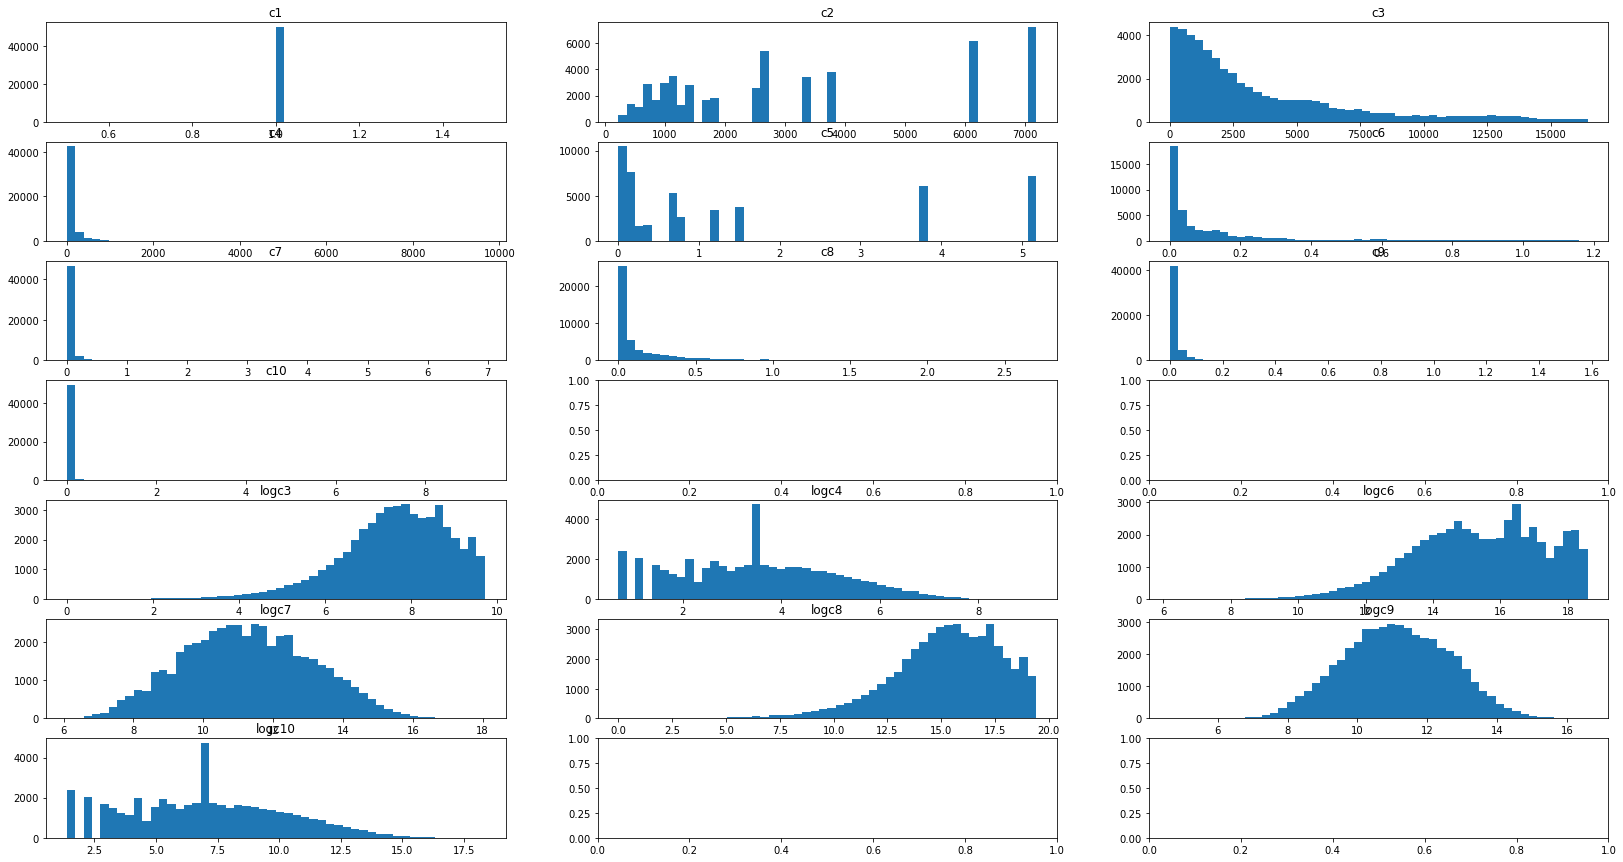

In [25]:
pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(df_cl[['rest_in_city', 'Ranking','Number of Reviews']].fillna(1))

# Из всех колонок poly_frame наилучший MAE выдает логарифм C9
poly_frame = pd.DataFrame(poly_features, columns=['c1','c2','c3','c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10'])


fig, axes = plt.subplots(7,3, figsize=(28,15))

axes[0][0].hist(poly_frame['c1'], bins=50)
axes[0][0].set_title('c1')

axes[0][1].hist(poly_frame['c2'], bins=50)
axes[0][1].set_title('c2')

axes[0][2].hist(poly_frame['c3'], bins=50)
axes[0][2].set_title('c3')

axes[1][0].hist(poly_frame['c4'], bins=50)
axes[1][0].set_title('c4')

axes[1][1].hist(poly_frame['c5'], bins=50)
axes[1][1].set_title('c5')

axes[1][2].hist(poly_frame['c6'], bins=50)
axes[1][2].set_title('c6')

axes[2][0].hist(poly_frame['c7'], bins=50)
axes[2][0].set_title('c7')

axes[2][1].hist(poly_frame['c8'], bins=50)
axes[2][1].set_title('c8')

axes[2][2].hist(poly_frame['c9'], bins=50)
axes[2][2].set_title('c9')

axes[3][0].hist(poly_frame['c10'], bins=50)
axes[3][0].set_title('c10')

axes[4][0].hist(np.log(poly_frame['c3']), bins=50)
axes[4][0].set_title('logc3')

axes[4][1].hist(np.log(poly_frame['c4']), bins=50)
axes[4][1].set_title('logc4')

axes[4][2].hist(np.log(poly_frame['c6']), bins=50)
axes[4][2].set_title('logc6')

axes[5][0].hist(np.log(poly_frame['c7']), bins=50)
axes[5][0].set_title('logc7')

axes[5][1].hist(np.log(poly_frame['c8']), bins=50)
axes[5][1].set_title('logc8')

axes[5][2].hist(np.log(poly_frame['c9']), bins=50)
axes[5][2].set_title('logc9')

axes[6][0].hist(np.log(poly_frame['c10']), bins=50)
axes[6][0].set_title('logc10')

#df_cl = pd.concat([df_cl, poly_frame['c9']], axis=1)
#MAE: 0.21098899999999998

# т.к. из всех признаков логарифм с9 имеет распределение, более всех остальных напоминающее нормальное, именно его и 
# добавим в чистовую модель
df_cl = pd.concat([df_cl, np.log(poly_frame['c9'])], axis=1)
#MAE: 0.209254


## кол-во ревью в ресторанах города и еще вариант нормализации ранга

In [26]:
# Нормализуем количество отзывов относительно максимального в городе
# reviews_in_city - это словарь, содержащий все уникальные города из датасета в качестве ключей 
# и суммарное кол-во ревью в качестве значений:
reviews_in_city = df_dr.groupby(['City'])['Number of Reviews'].max().sort_values(ascending=False).to_dict()
# с помощью to_replace и полученного словаря получаем поле кол-во ревью во всех ресторанах города
df_dr['reviews_in_city'] = df_dr['City'].replace(to_replace=reviews_in_city)
# нормализуем ранг к полученному признаку:
df_cl['norm_rank_reviews'] = df_dr['Ranking'] / df_dr['reviews_in_city']

# MAE: 0.2095585
#np.log(df_cl['norm_rank_reviews']).hist(bins=50) логарифмизация данного параметра значительно ухудшает MAE

## Stage 2 MAE = 0.2095585

###### Следующим промежуточным итогом фиксируем, что исследованы Ranking и Number of Reviews, получены 2 варианта нормализации Ranking и полиномиальные признаки из в том числе данных полей

## Рассмотрим теперь Cuisine Styles


In [27]:
# Заполним пустые значения
df_dr['Cuisine Style'] = df_dr['Cuisine Style'].fillna("['Unknown']")

# Преобразуем строки в список
df_dr['Cuisine Style'] = df_dr['Cuisine Style'].apply(
    lambda x: eval(x))  # transforming to a list

# введем признак количество кухонь у ресторана
df_cl['Cuisines_count'] = df_dr['Cuisine Style'].apply(lambda x: len(x))
# MAE: 0.20770300000000003

# Создим dummy переменные для типов кухоноь
# Cuisines_dum = pd.get_dummies(df_dr['Cuisine Style'].explode()).reset_index().groupby('index').sum()

# Присоединяем к data
# df_cl = pd.concat([df_cl, Cuisines_dum], axis = 1)
# MAE: 0.20896099999999998 ухудшился, поэтому не добавляем к чистовику

<AxesSubplot:>

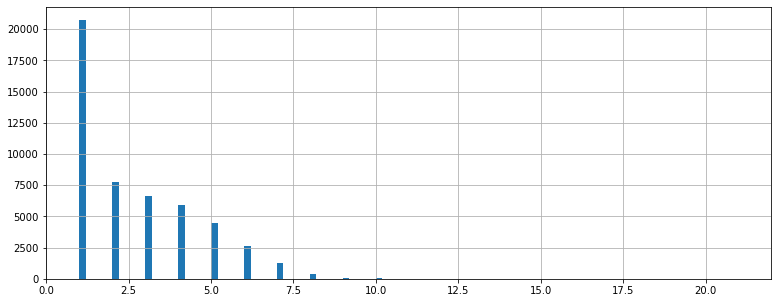

In [28]:
df_cl['Cuisines_count'].hist(bins=100)
# подавляющее большинство ресторанов специализируются на одном типе кухне

## Рассмотрим ревью

In [29]:
pattern = re.compile('\[\[.*\]\]')
nan = None

# ф-я принимает на вход датасет, колонку с датами и содержанием ревью разделяет на несколько колонок:
# первый и последний ревью и их даты
def review_extraction(row):
    cell = row['Reviews']
    aux_list = [[], []]  
    if type(cell) == str and pattern.fullmatch(cell):  
        aux_list = eval(cell)  

    row['first_review'] = aux_list[0][1] if len(aux_list[0]) > 1 else nan
    row['last_review'] = aux_list[0][0] if len(aux_list[0]) > 0 else nan

    row['first_date'] = pd.to_datetime(
        aux_list[1][1] if len(aux_list[1]) > 1 else nan , format='%m/%d/%Y', errors='coerce')
    row['last_date'] = pd.to_datetime(
        aux_list[1][0] if len(aux_list[1]) > 0 else nan, format='%m/%d/%Y', errors='coerce')

    return row


df_dr = df_dr.apply(review_extraction, axis=1)
#df_dr.sample(3)


In [30]:
# введем признак кол-во дней между первым и последним ревью
df_cl['reviews_diff'] = abs(df_dr['last_date'] - df_dr['first_date']).apply(lambda x: x.days).fillna(1)
#MAE: 0.20372649999999998


In [31]:
df_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Markup                            50000 non-null  int64  
 1   Ranking                           50000 non-null  float64
 2   Rating                            50000 non-null  float64
 3   Price_Range_num                   50000 non-null  float64
 4   Number_of_Reviews_isNAN           50000 non-null  uint8  
 5   Number of Reviews                 50000 non-null  float64
 6   City_Amsterdam                    50000 non-null  uint8  
 7   City_Athens                       50000 non-null  uint8  
 8   City_Barcelona                    50000 non-null  uint8  
 9   City_Berlin                       50000 non-null  uint8  
 10  City_Bratislava                   50000 non-null  uint8  
 11  City_Brussels                     50000 non-null  uint8  
 12  City

In [32]:
# у признаков norm_rank_reviews (ранг нормализованный по кол-ву ревью) и Ranking_norm (ранг нормализованный 
# по максимальному значению) также сильная корреляция, но удаление norm_rank_reviews из модели существенно 
# снизило MAE 0.2046->0.2090

#df_cl.drop(['norm_rank_reviews'],axis = 1)

## Выбросы

<AxesSubplot:>

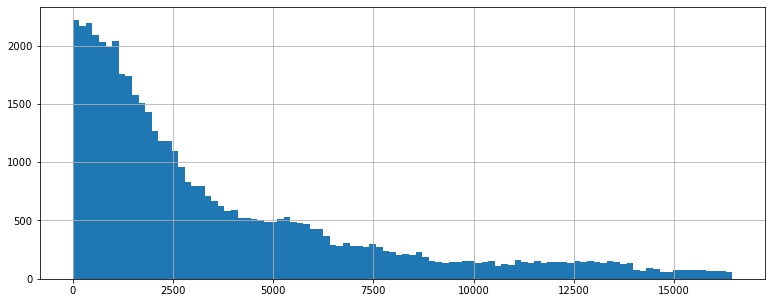

In [33]:
df_cl.Ranking.hist(bins=100)

###### Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
###### по логике, Ranking д.б. не больше кол-ва ресторанов в городе, но таких строк больше половины датасета!

In [34]:
len(df_cl[df_cl.Ranking > df_cl.rest_in_city])

28364

In [35]:
# ну посмотрим, как повлияет на MAE очистка половины датасета
#df_cl = df_cl[df_cl.Ranking > df_cl.rest_in_city]
#df_cl['Ranking1'] = df_cl['Ranking']/df_cl['rest_in_city']
# без очистки строк, где Ranking>rest_in_city и без ревью MAE: 0.2091355
# с очисткой строк, где Ranking>rest_in_city и без ревью MAE: 0.2322187004754358
# с очисткой строк, где Ranking>rest_in_city и с Ranking/rest_in_city  и без ревью MAE: 0.2322187004754358

#### Очистка выбросов по логике дала плохой результат, значит логика не логичная
#### попробуем фильтрануть выбросы по Ranking по IQR:

16444.0
1.0
25-й перцентиль: 972.0, 75-й перцентиль: 5241.0, IQR: 4269.0, Границы выбросов: [-5431.5,11644.5].


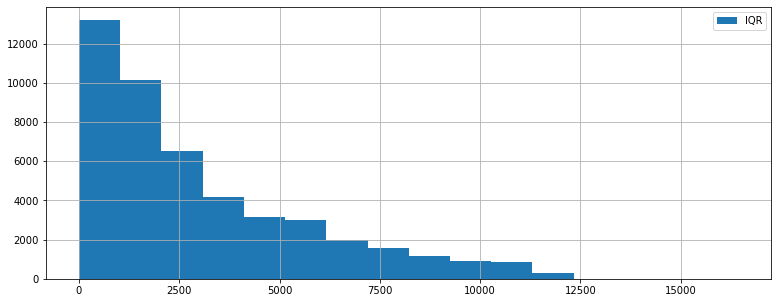

In [36]:
print(df_cl.Ranking.max())
print(df_cl.Ranking.min())
print_hist(df_cl.Ranking)

<AxesSubplot:>

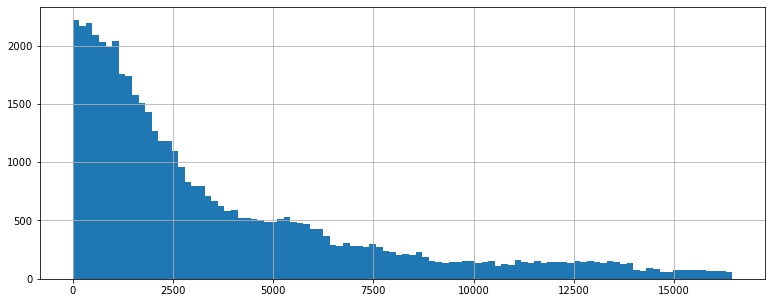

In [37]:
bounds = get_bounds(df_cl['Ranking'])
#df_cl = df_cl[df_cl['Ranking']<bounds[4]] 
#df_cl['Ranking_norm'] = df_dr['Ranking'] / df_dr['City'].map(df_dr.groupby(['City'])['Ranking'].max())

# без фильтрации выбросов по IQR и без ревью MAE: 0.20874849999999998
# c фильтрацией выбросов по IQR и без ревью MAE: 0.2040428480068216
df_cl.Ranking.hist(bins=100)

#### Но просто удалить строки с выбросами по Ranking мы не можем, т.к. чистовой датасет содержит в себе и строки из  kaggle task, и при удалении выбросов удаляются и строки из kaggle task. А замена выбросов на медиану по городу дает уже худший MAE

In [38]:
#median_ranks = df_dr.groupby(['City'])['Ranking'].median().sort_values(ascending=False).to_dict()
#new_ranks = df_dr.apply(lambda row : row.Ranking if row.Ranking < 11644.5 else median_ranks[row.City], axis =1)
#df_cl['Ranking'] = new_ranks
# MAE: 0.21149449999999997



<AxesSubplot:>

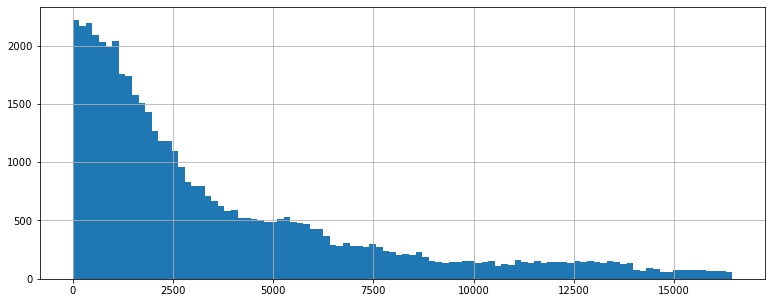

In [39]:
df_cl['Ranking'].hist(bins=100)

###### поэтому, оставляем выбросы. kaggle task также содержит выбросы по Ranking, полагаю, при таком варианте модель отработает лучше на kaggle task

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [40]:
# Теперь выделим тестовую и контрольную части данных
train_data = df_cl.query('Markup == 1').drop(['Markup'], axis=1)
control_data = df_cl.query('Markup == 0').drop(['Markup'], axis=1)

y = train_data.Rating.values            
X = train_data.drop(['Rating'], axis=1)


# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_control, y_train, y_control = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

# проверяем
control_data.shape, train_data.shape, X.shape, X_train.shape, X_control.shape

# ((10000, 35), (40000, 35), (40000, 34), (32000, 34), (8000, 34))


((10000, 44), (40000, 44), (40000, 43), (30000, 43), (10000, 43))

In [41]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_control, y_train, y_control = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [42]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [43]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
y_pred = regr.predict(X_control)

In [44]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Mean Absolute Error (MAE) - среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_control, y_pred))

MAE: 0.2062615


In [45]:
X_train

,Ranking,Price_Range_num,Number_of_Reviews_isNAN,Number of Reviews,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Ranking_norm,rest_in_city,Log_Norm_Ranking_To_rest_in_city,c9,norm_rank_reviews,Cuisines_count,reviews_diff
15217,182.0,1.0,0,28.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.160070,488,-8.022457,8.536211,0.130841,7,20.0
18773,3514.0,2.0,0,17.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.450744,3395,-8.926915,10.997724,0.703363,2,132.0
11273,994.0,2.0,0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.461467,925,-7.603138,8.288032,0.421902,1,1.0
41285,637.0,1.0,0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.429245,642,-7.310315,8.759355,0.198690,2,161.0
47464,358.0,2.0,0,77.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.025597,6108,-12.382634,10.224338,0.046969,4,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25451,2795.0,1.0,0,17.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.438638,2705,-8.726938,10.768801,1.086703,1,114.0
10288,2736.0,2.0,0,13.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.436016,2694,-8.728859,10.479202,0.430189,1,1.0
33177,7054.0,2.0,0,139.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.504362,6108,-9.401817,13.795824,0.925479,4,46.0
38421,1711.0,2.0,0,310.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.122337,6108,-10.818334,13.181406,0.224482,2,84.0


<AxesSubplot:>

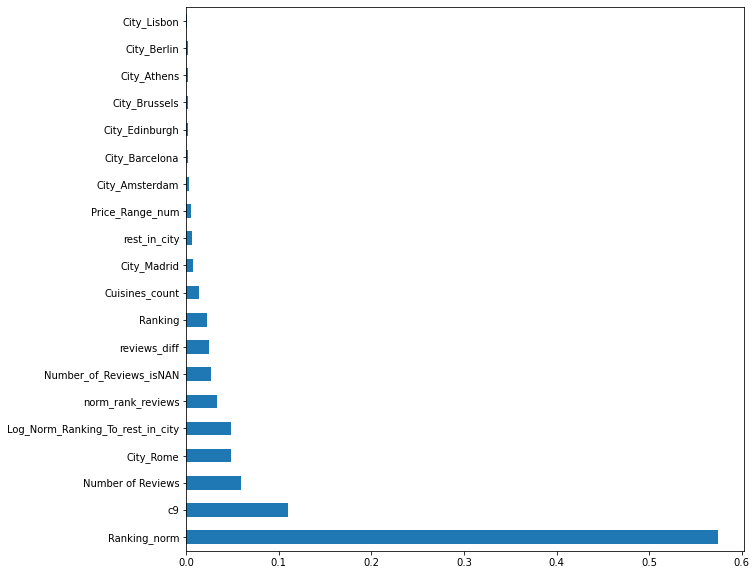

In [46]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

## Изучение матрицы корреляций

<AxesSubplot:>

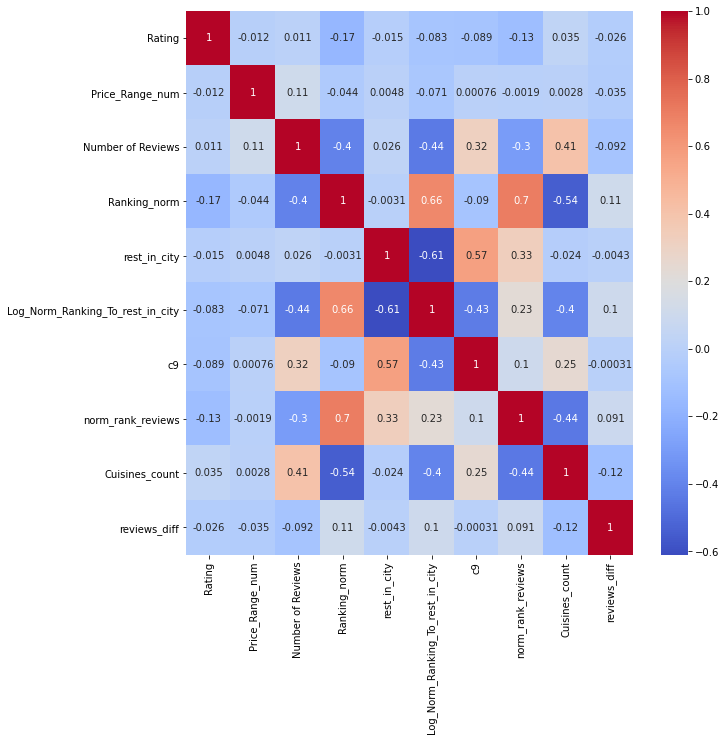

In [47]:
correlation=df_cl[['Rating','Price_Range_num','Number of Reviews',
                   'Ranking_norm','rest_in_city',
                   'Log_Norm_Ranking_To_rest_in_city','c9',
                   'norm_rank_reviews','Cuisines_count','reviews_diff']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')


## Submission

In [48]:
# берем контрольный датасет, убираем ранее заполненную нулями колонку
control_data = control_data.drop(['Rating'], axis=1)
# Получаем предсказания нашей модели
predict_submission = regr.predict(control_data)

# округляем, чтобы рез-т был в том же видеЮ что и в тренировочном датасете
predict_submission = np.array([round_rating_pred(x) for x in predict_submission])
predict_submission

# добавляем рез-т в датасет для kaggle
sample_submission['Rating'] = predict_submission
# Вывводим датасет в файл
sample_submission.to_csv(DATA_DIR+'submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.0
8,id_8,4.5
9,id_9,4.5
